# Extrapolate bias-corrected TF from EN4 grid to ISMIP
Based on Donald's code for extrapolating ocean properties.  Accounts for effective depth using lookup table.

21 Jul 2025 | EHU
- 24 Jul: Attempt with xarray functionality, as NetCDF complaining about shape of grid.  Tried to convert coords on a single slice, but this did not work.  Try making meshgrid?  Or try CESM test case instead of EN4?
- 25 Jul: Meshgrid worked for EN4.  Adapted for use with CESM2-WACCM test file, which already has 2D lat/lon, and this worked well with original pyproj functionality.  Confirmed that mapped values at least look like Greenland area.
- 28 Jul: fixed later part of code that maps to ISMIP grid. Dimensions were out of order.
- TODO: check why all cells have same maximum depth of non-NaN values.
- TODO: confirm whether to reprocess Step 1 TF with pressure dependence of freezing point removed, to be accounted for here instead.

In [1]:
# libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
from netCDF4 import Dataset
import os
from pyproj import Transformer
from scipy.interpolate import interp1d


In [2]:
## load effective geometry (spatial look-up table)

# files
xy_eff_file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Slater-extrapolate/XY_eff.nc'
z_eff_file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Slater-extrapolate/z_eff.nc'

# effective geometry
# NB replace masked values with NaNs
X_eff = nc.Dataset(xy_eff_file).variables['X_eff'][:].filled(np.nan)
Y_eff = nc.Dataset(xy_eff_file).variables['Y_eff'][:].filled(np.nan)
z_eff = nc.Dataset(z_eff_file).variables['z_eff'][:].filled(np.nan)

# ismip coordinates at which effective geometry applies
x = nc.Dataset(xy_eff_file).variables['x'][:].filled(np.nan)
y = nc.Dataset(xy_eff_file).variables['y'][:].filled(np.nan)
X, Y = np.meshgrid(x, y)

# vertical grid of effective depths
z = np.flipud(np.unique(z_eff[z_eff<=0]))


Load CESM2 data to test the workflow.  Unlike Donald's original workflow, we are loading in pre-computed TF rather than ocean properties.

Note 22 Jul: Donald's workflow using NetCDF and pyproj had an error saying the size of the lat, lon, time dimensions were inconsistent.  Try with `rioxarray` instead, since this is already in the workflow.

25 Jul: `rioxarray` option not helpful here, but leaving this dataset read-in because it's helpful to orient.

In [3]:
## load and process data
import xarray
# import rioxarray
# import rasterio

## files
SelModel = 'CESM2-WACCM' ## model label for input and output
# model_file = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/gris-iceocean-outfiles/tfQDM-AllLevels-CESM-2025-04-11.nc'
model_path = '/Users/eultee/Library/CloudStorage/OneDrive-NASA/Data/gris-iceocean-outfiles/Summer25Test/'
model_file = model_path+'tf-{}-185001-201412-20250707.nc'.format(SelModel)

ds_model = xr.open_dataset(model_file, decode_times='timeDim')

# ds_slice = ds_en4.sel(depth=500, method='nearest')

# WGS84 = rasterio.crs.CRS.from_epsg(4326)
# ds_slice.rio.write_crs(WGS84, inplace=True).rio.set_spatial_dims(
#     x_dim='lon',
#     y_dim='lat',
#     inplace=True,
# ).rio.write_coordinate_system(inplace=True)

# ds_slice

In [4]:
ds_model

<xarray.Dataset> Size: 14GB
Dimensions:  (nlat: 47, nlon: 320, lev: 60, time: 1980)
Coordinates:
    lat      (nlat, nlon) float64 120kB ...
  * lev      (lev) float64 480B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon      (nlat, nlon) float64 120kB ...
  * nlat     (nlat) int32 188B 338 339 340 341 342 343 ... 380 381 382 383 384
  * nlon     (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * time     (time) object 16kB 1850-01-15 13:00:00.000008 ... 2014-12-15 12:...
Data variables:
    TF       (time, lev, nlat, nlon) float64 14GB ...
Attributes:
    title:          Ocean thermal forcing for CESM2-WACCM
    summary:        TF computed following Verjans code, in a bounding box aro...
    institution:    NASA Goddard Space Flight Center
    creation_date:  2025-07-07 15:37:43

In [5]:
## load and process data

# cmip model coordinates
lat_model = nc.Dataset(model_file).variables['lat'][:].filled(np.nan)
lon_model_raw = nc.Dataset(model_file).variables['lon'][:].filled(np.nan)
z_model = (nc.Dataset(model_file).variables['lev'][:].filled(np.nan))*0.01 ## correct units in cm in CESM2-WACCM
t_model = nc.Dataset(model_file).variables['time'][:].filled(np.nan)

lon_model = np.mod((lon_model_raw+180), 360) -180 ## put back on -180 to 180 axis
# lon_grid, lat_grid = np.meshgrid(lon_model, lat_model) ## necessary if 1D arrays


# get coordinates in EPSG:3413 for consistency with ismip grid
mapping = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)
x_model, y_model = mapping.transform(lon_model, lat_model)

# ## load TF
TF_model_raw = nc.Dataset(model_file).variables['TF'][:]
TF_model_nonneg = np.ma.masked_less(TF_model_raw, 0) ## filter out erroneous negative values
TF_model_pos = np.ma.filled(TF_model_nonneg, fill_value=0) ## and assign 0
TF_model = np.ma.masked_greater(TF_model_pos, 1.1e10) ## filter out fill value

In [6]:
np.max(TF_model)

np.float64(19.848025638275146)

In [7]:
np.min(TF_model)

np.float64(0.0)

In [8]:
## we can tell from the read-in above that TF_model from EN4 has dimensions (depth, lat, lon, time)
## change to ## depth, time, lat, lon as the code is expecting

## for CESM2-WACCM, it is (time, depth, lat, lon)

# crop CMIP output to area of interest around Greenland
xlims = [np.min(x), np.max(x)]
ylims = [np.min(y), np.max(y)]
x_model = x_model.flatten()
y_model = y_model.flatten()
inds = np.where((x_model > xlims[0]) & (x_model < xlims[1]) & (y_model > ylims[0]) & (y_model < ylims[1]))[0]
x_model = x_model[inds]
y_model = y_model[inds]

## make a filled version of the masked array for interpolation and shuffling
TF_mod_filled = np.ma.filled(TF_model, fill_value=np.nan) ## filter out fill value
TF_shuffled = np.transpose(TF_mod_filled, axes=[1, 0, 2, 3])
TF_nop_model_orig_crop = TF_shuffled.reshape(TF_shuffled.shape[0], ## depth
                                          TF_shuffled.shape[1], ## time?
                                          TF_shuffled.shape[2]*TF_shuffled.shape[3])[:,:,inds] ## should be x*y
TF_nop_model_orig_crop = np.ma.masked_greater(TF_nop_model_orig_crop, 1.1e10)

# interpolate the thermal forcing from cmip vertical grid onto the effective depth grid
interp_TF = interp1d(z_model, TF_nop_model_orig_crop, axis=0, bounds_error=False, fill_value='extrapolate')
## note which axis is depth/z. Donald's default had axis=1, but checking the shape of TF_model 
## showed that it had depth as its zeroth axis. Consistent with TF_shuffled order above
TF_nop_model = interp_TF(z)

# get max depth at which each cmip point has a thermal forcing value
depth_model = np.full(x_model.shape, np.nan)
for i in range(len(x_model)):
    tf = TF_nop_model[:,0,i] ## careful with order of axes here
    if np.all(np.isnan(tf)):
        continue
    elif np.all(~np.isnan(tf)):
        depth_model[i] = z[-1]
    else:
        first_nan = np.argmax(np.isnan(tf))
        depth_model[i] = z[first_nan-1]
        

In [9]:
np.nanmax(TF_nop_model)

np.float64(953.9835896341801)

Frankly not sure why this has such a high max.  Probably an extrapolation problem...should be modified.  Anyway, the plot looks mostly okay below.

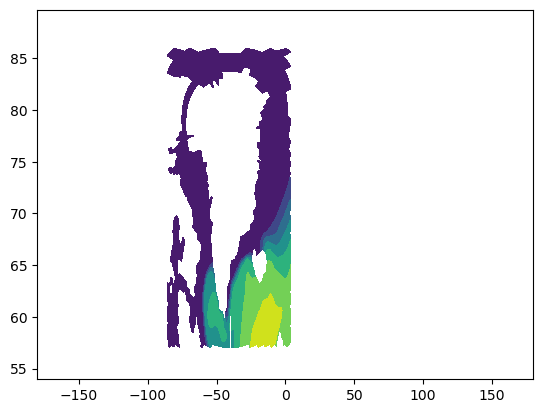

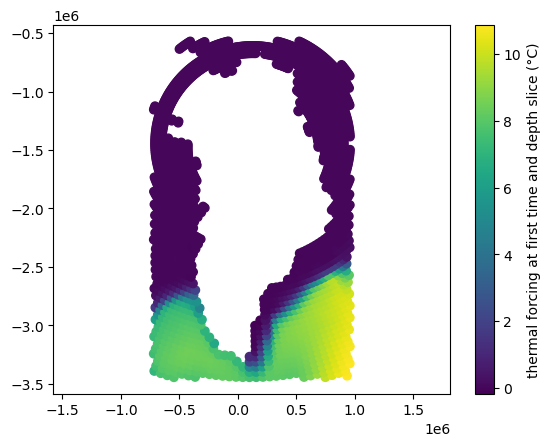

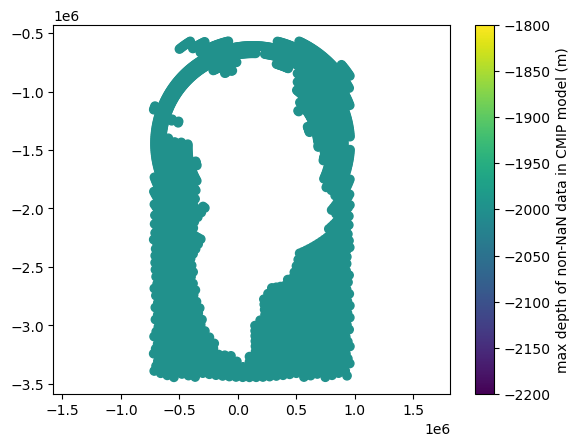

In [10]:
## plots to check things make sense

fig, ax = plt.subplots()
ax.contourf(lon_model, lat_model, TF_model[0,0, :,:])
plt.show()

plt.scatter(x_model, y_model, c=TF_nop_model[0,0,:])
plt.colorbar(label='thermal forcing at first time and depth slice (°C)')
plt.axis('equal')
plt.show()

plt.scatter(x_model, y_model, c=depth_model)
plt.colorbar(label='max depth of non-NaN data in CMIP model (m)')
plt.axis('equal')
plt.show()


In [11]:
## match ismip points to cmip points

# linear versions of effective position arrays
X_eff_flat = X_eff.flatten()
Y_eff_flat = Y_eff.flatten()

# initialise arrays that will store the linear index of the required cmip point
x_ind = np.full_like(X_eff_flat, np.nan, dtype=float)
z_ind = np.full_like(X_eff_flat, np.nan, dtype=float)

# loop over effective depth grid
for k, z_val in enumerate(z):
    
    # get all ismip points with this effective depth
    i_inds = np.where(z_eff.flatten() == z_val)[0]

    # save the effective depth index
    z_ind[i_inds] = k

    # get all cmip points that have data at this depth
    c_inds = np.where(depth_model.flatten() <= z_val)[0]

    # loop over ismip points with this effective depth and find closest cmip point to effective position
    for i in i_inds:
        dsq = (x_model[c_inds] - X_eff_flat[i])**2 + (y_model[c_inds] - Y_eff_flat[i])**2
        id_min = np.argmin(dsq)
        x_ind[i] = c_inds[id_min]
    

In [12]:
## now we fill the ismip TF using the matched cmip positions and depths

# initialise array
TF_nop = np.full((len(t_model), len(x_ind)), np.nan)

# fill array knowing that the ismip TF(t,i) equals the cmip TF(t,z_ind(i),x_ind(i))
for i in range(len(x_ind)):
    if not np.isnan(x_ind[i]):
        # TF_nop[:, i] = TF_nop_model[:, int(z_ind[i]), int(x_ind[i])]
        ## we ordered differently above in TF_nop_model -- depth first
        TF_nop[:,i] = TF_nop_model[int(z_ind[i]), :, int(x_ind[i])]

# reshape array for consistency with ismip coordinates
TF_nop = TF_nop.reshape(len(t_model), X.shape[0], X.shape[1])


In [13]:
## final corrections

## Freezing point dependence on pressure already included Step 1 computation
## correct for the freezing point dependence on pressure
TF = np.full_like(TF_nop, np.nan, dtype=float)
l3 = 7.61e-4; # dependence of freezing point on depth
for k in range(TF_nop.shape[0]):
    TF[k, :, :] = TF_nop[k, :, :] - l3 * z_eff
 

In [14]:
# # check if any TF are less than 0 and fix
# TF = np.full_like(TF_nop, np.nan, dtype=float) ## no pressure correction
inds = np.where(TF < 0)
num_corrected = len(inds[0])
if num_corrected > 0:
    TF[inds] = 0
    print(f"Warning: {num_corrected} pixels corrected for TF<0")

# all the unconnected below sea level points must be assigned TF=0 -  these points have z_eff=NaN
TF[:, np.isnan(z_eff)] = 0

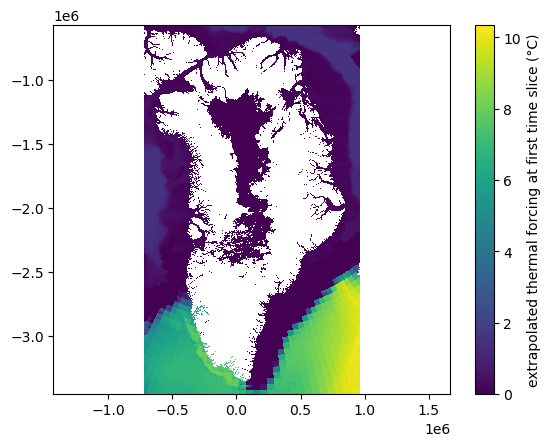

In [15]:
## plot an example of the result

plt.pcolormesh(X, Y, TF[0, :, :])
cbar = plt.colorbar()
cbar.set_label('extrapolated thermal forcing at first time slice (°C)')
plt.axis('equal')
plt.show()

In [16]:
## write to output file
from datetime import date

# file name
output_file = 'TF_example-{}-{}.nc'.format(SelModel, date.today())

# delete previous file if it exists
if os.path.exists(output_file):
    os.remove(output_file)

# write netcdf
with Dataset(output_file, 'w', format='NETCDF4') as nc:

    # dimensions
    nc.createDimension('x', len(x))
    nc.createDimension('y', len(y))
    nc.createDimension('t', len(t_model))

    # variables
    x_var = nc.createVariable('x', np.float32, ('x',))  # 'f4' = single precision float
    y_var = nc.createVariable('y', np.float32, ('y',))
    t_var = nc.createVariable('t', np.float32, ('t',))
    TF_var = nc.createVariable('TF', np.float32, ('t', 'y', 'x'), zlib=True, complevel=9)

    # Write data
    x_var[:] = np.array(x, dtype=np.float32)
    y_var[:] = np.array(y, dtype=np.float32)
    t_var[:] = np.array(t_model, dtype=np.float32)
    TF_var[:, :, :] = np.array(TF, dtype=np.float32)
